In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms

In [2]:
# https://discuss.pytorch.org/t/view-classify-in-module-helper/30279/6

def view_classify(img, ps):

    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)


In [3]:
# Define a transform to normalize the data (Preprocessing)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5)) ])

# Download and load the training data
trainset    = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset    = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


0it [00:00, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw


0it [00:00, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


0it [00:00, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch-base_1635177256515/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

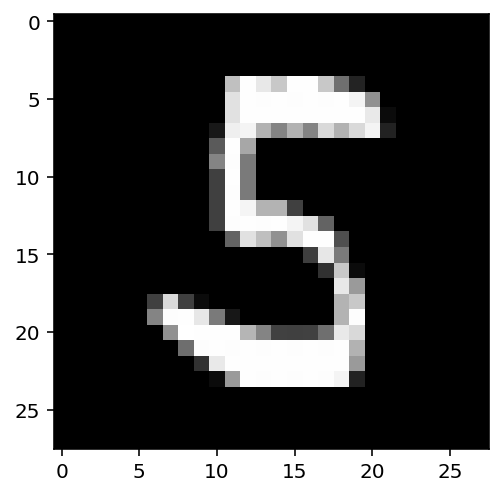

In [5]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [6]:
class Network(nn.Module):
    
    # Defining the layers, 128, 64, 10 units each
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    # Forward pass through the network, returns the output logits
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

model = Network() 
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [7]:
# Hyperparameters for our network
input_size   = 784
hidden_sizes = [128, 64]
output_size   = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


In [8]:
model = nn.Sequential(OrderedDict([
          ('fc1',   nn.Linear(input_size, hidden_sizes[0])),
          ('relu1', nn.ReLU()),
          ('fc2',   nn.Linear(hidden_sizes[0], hidden_sizes[1])),
          ('relu2', nn.ReLU()),
          ('output', nn.Linear(hidden_sizes[1], output_size)),
          ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [9]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[ 0.0199,  0.0163, -0.0101,  ..., -0.0237,  0.0247,  0.0348],
        [-0.0008, -0.0253,  0.0059,  ...,  0.0168, -0.0065,  0.0232],
        [-0.0015,  0.0014,  0.0323,  ..., -0.0285,  0.0079,  0.0115],
        ...,
        [-0.0056, -0.0247,  0.0316,  ...,  0.0303,  0.0207, -0.0232],
        [-0.0271,  0.0235, -0.0289,  ..., -0.0216, -0.0197,  0.0075],
        [-0.0064, -0.0170, -0.0291,  ..., -0.0152,  0.0040, -0.0264]],
       requires_grad=True)
Parameter containing:
tensor([-0.0080, -0.0298,  0.0188,  0.0078, -0.0352, -0.0102, -0.0171, -0.0179,
        -0.0164, -0.0214, -0.0001, -0.0029,  0.0056,  0.0010, -0.0149, -0.0107,
        -0.0067, -0.0258,  0.0202, -0.0097,  0.0133,  0.0004,  0.0320,  0.0039,
         0.0024, -0.0246,  0.0085,  0.0312,  0.0038, -0.0249, -0.0251,  0.0340,
        -0.0133,  0.0337,  0.0029, -0.0295,  0.0254,  0.0035, -0.0100,  0.0120,
         0.0072,  0.0203, -0.0030, -0.0300, -0.0178,  0.0156,  0.0064, -0.0158,
        -0.0279

In [10]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[-1.2000e-02, -6.4618e-03, -8.7234e-04,  ...,  5.5578e-03,
         -8.1492e-03, -1.7415e-02],
        [-1.8810e-02, -1.6217e-04,  5.4637e-05,  ..., -8.7224e-03,
         -5.5043e-03,  9.9275e-03],
        [-7.0839e-03, -1.9224e-02,  9.6138e-03,  ...,  1.6037e-02,
         -1.3157e-02, -6.8760e-03],
        ...,
        [ 6.2614e-03, -6.7028e-03,  4.9137e-03,  ...,  1.5674e-03,
         -3.0590e-03, -3.2206e-03],
        [-4.4903e-04, -1.4519e-03, -9.0157e-03,  ..., -9.2469e-03,
         -5.9174e-03, -1.0564e-02],
        [ 2.4822e-02,  1.0975e-02, -1.4334e-02,  ..., -1.5705e-03,
         -1.0037e-02, -2.0661e-03]])

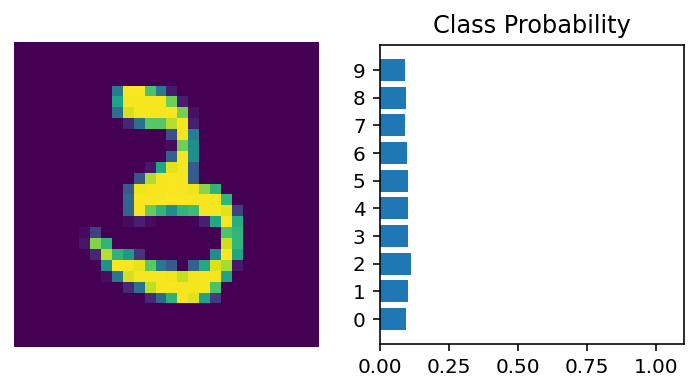

In [12]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)

In [13]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[-0.5582, -0.7870],
        [ 1.1028, -0.2574]], requires_grad=True)


In [14]:
y = x**2
print(y)

tensor([[0.3116, 0.6194],
        [1.2162, 0.0663]], grad_fn=<PowBackward0>)


In [15]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

In [16]:
z = y.mean()
print(z)

tensor(0.5534, grad_fn=<MeanBackward0>)


In [17]:
print(x.grad)

None


In [18]:
z.backward()
print(x.grad)
print(x/2)

tensor([[-0.2791, -0.3935],
        [ 0.5514, -0.1287]])
tensor([[-0.2791, -0.3935],
        [ 0.5514, -0.1287]], grad_fn=<DivBackward0>)


In [19]:
# Hyperparameters for our network
input_size   = 784
hidden_sizes = [128, 64]
output_size  = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
          ('fc1', nn.Linear(input_size, hidden_sizes[0])),
          ('relu1', nn.ReLU()),
          ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
          ('relu2', nn.ReLU()),
          ('logits', nn.Linear(hidden_sizes[1], output_size))]))

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [21]:
print('Initial weights - ', model.fc1.weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model.fc1.weight.grad)
optimizer.step()

Initial weights -  Parameter containing:
tensor([[ 0.0119,  0.0024, -0.0110,  ..., -0.0094,  0.0127,  0.0232],
        [-0.0136,  0.0227, -0.0002,  ..., -0.0287, -0.0311, -0.0019],
        [ 0.0038, -0.0274, -0.0098,  ...,  0.0253,  0.0314, -0.0018],
        ...,
        [-0.0022, -0.0189,  0.0098,  ...,  0.0094, -0.0333,  0.0178],
        [-0.0107, -0.0129,  0.0182,  ...,  0.0015,  0.0235,  0.0232],
        [-0.0235, -0.0134,  0.0314,  ...,  0.0176,  0.0170,  0.0225]],
       requires_grad=True)
Gradient - tensor([[ 0.0012,  0.0012,  0.0012,  ...,  0.0012,  0.0012,  0.0012],
        [-0.0020, -0.0020, -0.0020,  ..., -0.0020, -0.0020, -0.0020],
        [ 0.0010,  0.0010,  0.0010,  ...,  0.0010,  0.0010,  0.0010],
        ...,
        [-0.0018, -0.0018, -0.0018,  ..., -0.0018, -0.0018, -0.0018],
        [ 0.0016,  0.0016,  0.0016,  ...,  0.0016,  0.0016,  0.0016],
        [ 0.0048,  0.0048,  0.0048,  ...,  0.0048,  0.0048,  0.0048]])


In [22]:
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[ 0.0119,  0.0024, -0.0110,  ..., -0.0094,  0.0127,  0.0232],
        [-0.0135,  0.0227, -0.0002,  ..., -0.0287, -0.0311, -0.0018],
        [ 0.0038, -0.0274, -0.0098,  ...,  0.0253,  0.0314, -0.0018],
        ...,
        [-0.0022, -0.0189,  0.0098,  ...,  0.0094, -0.0333,  0.0179],
        [-0.0107, -0.0129,  0.0182,  ...,  0.0015,  0.0234,  0.0232],
        [-0.0236, -0.0134,  0.0313,  ...,  0.0176,  0.0170,  0.0225]],
       requires_grad=True)


In [23]:
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [24]:
epochs = 3
print_every = 40

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):

        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0

Epoch: 1/3
	Iteration: 0	 Loss: 0.0580
	Iteration: 40	 Loss: 2.2962
	Iteration: 80	 Loss: 2.2714
	Iteration: 120	 Loss: 2.2535
	Iteration: 160	 Loss: 2.2333
	Iteration: 200	 Loss: 2.2082
	Iteration: 240	 Loss: 2.1859
	Iteration: 280	 Loss: 2.1615
	Iteration: 320	 Loss: 2.1405
	Iteration: 360	 Loss: 2.1094
	Iteration: 400	 Loss: 2.0632
	Iteration: 440	 Loss: 2.0301
	Iteration: 480	 Loss: 2.0053
	Iteration: 520	 Loss: 1.9471
	Iteration: 560	 Loss: 1.9140
	Iteration: 600	 Loss: 1.8517
	Iteration: 640	 Loss: 1.8262
	Iteration: 680	 Loss: 1.7489
	Iteration: 720	 Loss: 1.6825
	Iteration: 760	 Loss: 1.6350
	Iteration: 800	 Loss: 1.5378
	Iteration: 840	 Loss: 1.5147
	Iteration: 880	 Loss: 1.4307
	Iteration: 920	 Loss: 1.3628
Epoch: 2/3
	Iteration: 0	 Loss: 0.0361
	Iteration: 40	 Loss: 1.2759
	Iteration: 80	 Loss: 1.2207
	Iteration: 120	 Loss: 1.1539
	Iteration: 160	 Loss: 1.1278
	Iteration: 200	 Loss: 1.0802
	Iteration: 240	 Loss: 1.0203
	Iteration: 280	 Loss: 0.9728
	Iteration: 320	 Loss: 0.9

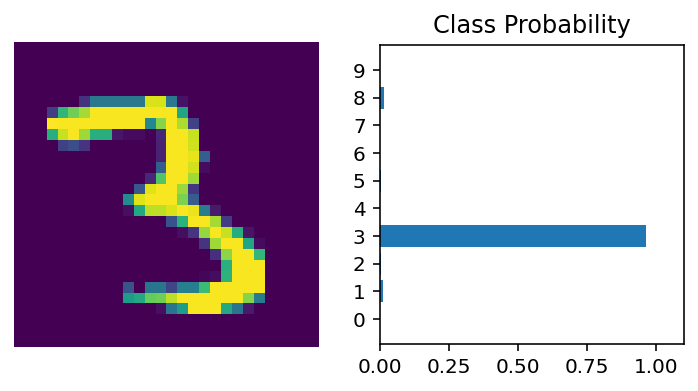

In [25]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
view_classify(img.view(1, 28, 28), ps)

# Now it's your turn to build a simple network, use any method I've covered so far. In the next notebook, you'll learn how to train a network so it can make good predictions,Build a network to classify the MNIST images with 3 hidden layers. Use 400 units in the first hidden layer, 200 units in the second layer, and 100 units in the third layer. Each hidden layer should have a ReLU activation function, and use softmax on the output layer

In [26]:
## TODO: Your network here

# model = nn.Sequential(OrderedDict([
#           ('fc1',   nn.Linear(input_size, 400)),
#           ('relu1', nn.ReLU()),
#           ('fc2',   nn.Linear(400, 200)),
#           ('relu2', nn.ReLU()),
#           ('fc3',   nn.Linear(200, 100)),
#           ('relu3', nn.ReLU()),
#           ('output', nn.Linear(100, 10)),
#           ('softmax', nn.Softmax(dim=1))]))
model = nn.Sequential(nn.Linear(input_size, 400),
                      nn.ReLU(),
                      nn.Linear(400, 200),
                      nn.ReLU(),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Linear(100, 10),
                      nn.Softmax(dim=1))
 
model

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
  (7): Softmax(dim=1)
)

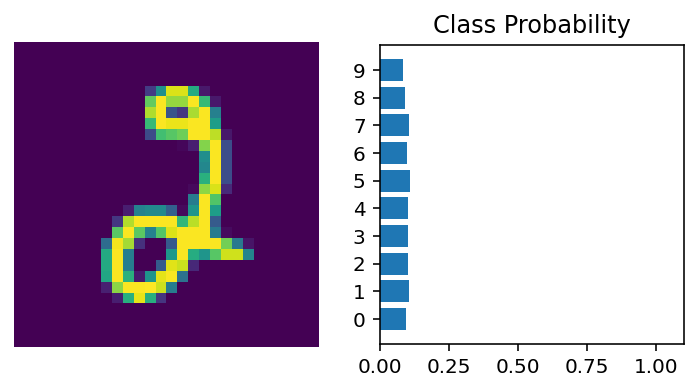

In [27]:
# Run this cell with your model to make sure it works
# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps)

# Train your network implementing the Pytorch training loop and 
  Note: If your model does not fit with the final softmax layer, you can remove this layer.
  Hint:  href="https://discuss.pytorch.org/t/training-loop-checking-validation-accuracy/78399">Training loop checking validation accuracy
  Research about model.train() model.eval() and with torch.no_grad() in Pytorch.

In [28]:
## TODO: Your training loop here

optimizer = optim.SGD(model.parameters(), lr=0.003)
epochs = 15
#print_every = 40

for e in range(epochs):
    # running_loss = 0
    #print(f"Epoch: {e+1}/{epochs}")
    train_correct_guess = 0
    train_total = 0

    for i, (images, labels) in enumerate(iter(trainloader)):

        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        model.train()

        optimizer.zero_grad()
        output = model.forward(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        train_pred_y = torch.max(output, 1)[1].data.squeeze()
        train_correct_guess += (train_pred_y == labels).float().sum()
        train_total += len(labels)
        accuracy = (train_pred_y == labels).sum().item() / float(labels.size(0))

    print(f'epoch {e+1} done: train accuracy of {(train_correct_guess/train_total).float()}')
    
    model.eval()
    with torch.no_grad():
        correct_guess = 0
        total = 0
        for i, (images, labels) in enumerate(iter(testloader)):
            images.resize_(images.size()[0], 784)
            test_output = model.forward(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct_guess += (pred_y == labels).float().sum()
            total += len(labels)
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    print(f'epoch {e+1} done: test accuracy of {(correct_guess/total).float()}')
    
    model.train()

epoch 1 done: train accuracy of 0.18361666798591614
epoch 1 done: test accuracy of 0.20479999482631683
epoch 2 done: train accuracy of 0.1721833348274231
epoch 2 done: test accuracy of 0.14959999918937683
epoch 3 done: train accuracy of 0.13040000200271606
epoch 3 done: test accuracy of 0.11980000138282776
epoch 4 done: train accuracy of 0.11500000208616257
epoch 4 done: test accuracy of 0.11389999836683273
epoch 5 done: train accuracy of 0.11241666972637177
epoch 5 done: test accuracy of 0.11349999904632568
epoch 6 done: train accuracy of 0.1192166656255722
epoch 6 done: test accuracy of 0.1535000056028366
epoch 7 done: train accuracy of 0.21175000071525574
epoch 7 done: test accuracy of 0.2689000070095062
epoch 8 done: train accuracy of 0.27799999713897705
epoch 8 done: test accuracy of 0.2825999855995178
epoch 9 done: train accuracy of 0.2856333255767822
epoch 9 done: test accuracy of 0.2964000105857849
epoch 10 done: train accuracy of 0.3036166727542877
epoch 10 done: test accuracy

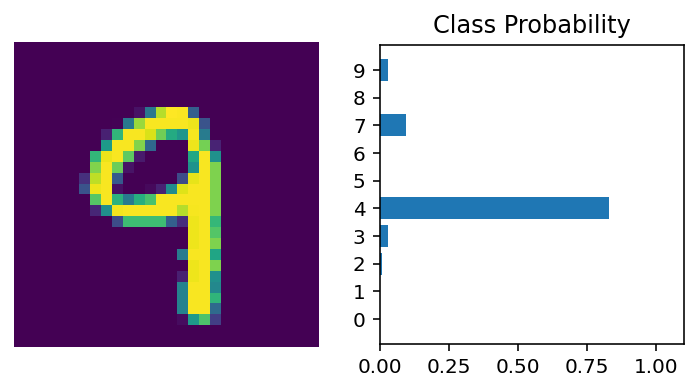

In [30]:
# Run this cell with your model to make sure it works and predicts well for the validation data
images, labels = next(iter(testloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps)

# Write the code for adding 
Early Stopping with patience to the training loop from scratch
Monitor the Validation loss every epoch, and if in 2 epochs, the validation loss does not improve, stop the training loop with break

In [ ]:
## TODO: Your training loop here

optimizer = optim.SGD(model.parameters(), lr=0.003)
epochs = 3

loss_anterior = 0

while True:

    for i, (images, labels) in enumerate(iter(trainloader)):

        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        model.train()

        optimizer.zero_grad()
        output = model.forward(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
    print(round(loss.item(),3),loss_anterior)
        
    model.eval()
    
    with torch.no_grad():
        correct_guess = 0
        total = 0
        for i, (images, labels) in enumerate(iter(testloader)):
            images.resize_(images.size()[0], 784)
            test_output = model.forward(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct_guess += (pred_y == labels).float().sum()
            total += len(labels)
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    print(f'epoch {e+1} done: accuracy of {(correct_guess/total).float()}')
    
    model.train()
    if round(loss.item(),3) == loss_anterior:
        break
    else:
        loss_anterior = round(loss.item(),3)

1.874 0
epoch 15 done: accuracy of 0.6585999727249146
1.793 1.874
epoch 15 done: accuracy of 0.7027000188827515
1.77 1.793
epoch 15 done: accuracy of 0.7225000262260437
1.806 1.77
epoch 15 done: accuracy of 0.7289000153541565
1.775 1.806
epoch 15 done: accuracy of 0.734499990940094
